In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 220
TIMESTEPS = 1
EPOCH=400
BATCH_SIZE=10

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

DATASET_DIR_NAME = "dataset\set04\\01_own"
SAMPLE_DATASET_NAME = "own_train"
ACTUAL_DATASET_NAME = "own_test"

MODEL_DIR_NAME = "dataset\set04\\01_own"
MODEL_NAME = "model_" + "set04_01_own"

RESULT_DIR_NAME = "dataset\set04\\01_own"
RESULT_NAME = "result_" + "set04_01_own"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own\own_train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,Co5mical,0.124989,0.000000,0.124989,0.123640,0.248628,0.123640,0.011015,0.134655,...,0.005318,0.005458,0.055285,0.056239,0.072921,0.073875,0.606169,0.731157,0.718543,0.843531
1,andy,Co5mical,0.101935,0.011014,0.112950,0.133594,0.235529,0.122580,0.046207,0.168787,...,0.006047,0.003990,0.047034,0.032436,0.077762,0.063164,0.616391,0.718327,0.697449,0.799384
2,andy,Co5mical,0.090341,-0.012504,0.077837,0.090850,0.181191,0.103354,0.054714,0.158068,...,0.003187,0.002233,0.024718,0.015517,0.056457,0.047256,0.550968,0.641309,0.628636,0.718976
3,andy,Co5mical,0.102711,0.011565,0.114277,0.110634,0.213346,0.099069,0.033884,0.132953,...,0.004878,0.005244,0.046083,0.048659,0.069841,0.072416,0.562252,0.664963,0.652923,0.755634
4,andy,Co5mical,0.127922,0.063317,0.191239,0.188074,0.315996,0.124757,0.023144,0.147900,...,0.016760,0.017344,0.101889,0.104127,0.129459,0.131697,0.638064,0.765986,0.722751,0.850673


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


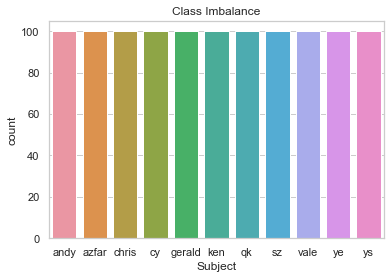

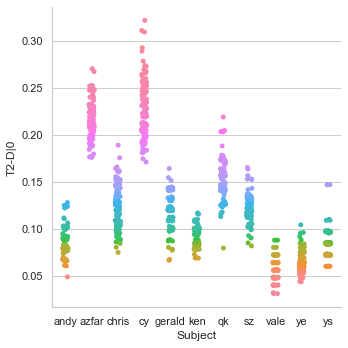

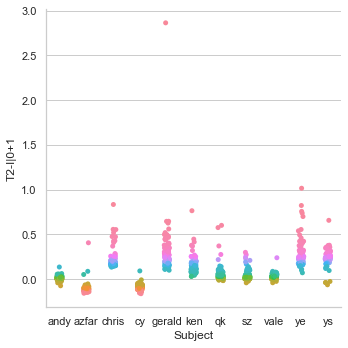

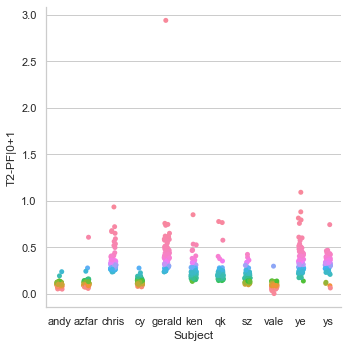

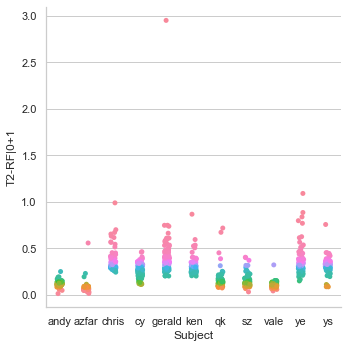

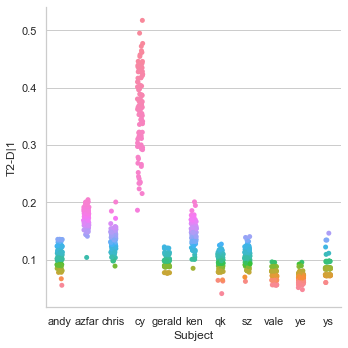

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye' 'ys']


X | Features | Dataset Shape: (1100, 220)
Y | Classes  | Dataset Shape: (1100, 11)
Number of Classes: 11


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (880, 1, 220)
Y train shape: (880, 11)
X test shape: (220, 1, 220)
Y test shape: (220, 11)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 11 classes.
Epoch 1/400
71/71 [==============================] - 7s 9ms/step - loss: 2.5711 - accuracy: 0.0767
Epoch 2/400
71/71 [==============================] - 1s 10ms/step - loss: 2.4686 - accuracy: 0.0795
Epoch 3/400
71/71 [==============================] - 1s 10ms/step - loss: 2.3575 - accuracy: 0.1151
Epoch 4/400
71/71 [==============================] - 1s 9ms/step - loss: 2.1916 - accuracy: 0.2045
Epoch 5/400
71/71 [==============================] - 1s 9ms/step - loss: 2.1072 - accuracy: 0.2259
Epoch 6/400
71/71 [==============================] - 1s 9ms/step - loss: 1.9987 - accuracy: 0.2727
Epoch 7/400
71/71 [==============================] - 1s 9ms/step - loss: 1.9402 - accuracy: 0.2543
Epoch 8/400
71/71 [==============================] - 1s 10ms/step - loss: 1.8766 - accuracy: 0.2713
Epoch 9/400
71/71 [==============================] - 1s 9ms/step - loss: 1.8503 - accuracy: 0.2770
Epoch 10/400
71/71 [==============================] - 1s 9ms/step - loss:

71/71 [==============================] - 1s 9ms/step - loss: 0.9952 - accuracy: 0.5909
Epoch 83/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0178 - accuracy: 0.5795
Epoch 84/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0700 - accuracy: 0.5696
Epoch 85/400
71/71 [==============================] - 1s 10ms/step - loss: 1.0575 - accuracy: 0.5753
Epoch 86/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0121 - accuracy: 0.5810
Epoch 87/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0302 - accuracy: 0.5838
Epoch 88/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0443 - accuracy: 0.5795
Epoch 89/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9990 - accuracy: 0.6009
Epoch 90/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0052 - accuracy: 0.5781
Epoch 91/400
71/71 [==============================] - 1s 10ms/step - loss: 1.0330 - accuracy: 0.5639
Epoch 92/4

71/71 [==============================] - 1s 9ms/step - loss: 0.7311 - accuracy: 0.7656
Epoch 164/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7841 - accuracy: 0.7457
Epoch 165/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7504 - accuracy: 0.7571
Epoch 166/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7110 - accuracy: 0.7699
Epoch 167/400
71/71 [==============================] - 1s 9ms/step - loss: 0.6600 - accuracy: 0.7713
Epoch 168/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7156 - accuracy: 0.7628
Epoch 169/400
71/71 [==============================] - 1s 10ms/step - loss: 0.6497 - accuracy: 0.7571
Epoch 170/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7025 - accuracy: 0.7628
Epoch 171/400
71/71 [==============================] - 1s 9ms/step - loss: 0.6458 - accuracy: 0.7670
Epoch 172/400
71/71 [==============================] - 1s 9ms/step - loss: 0.6520 - accuracy: 0.7699
Ep

71/71 [==============================] - 1s 9ms/step - loss: 0.5513 - accuracy: 0.8466
Epoch 245/400
71/71 [==============================] - 1s 9ms/step - loss: 0.4690 - accuracy: 0.8679
Epoch 246/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5585 - accuracy: 0.8466
Epoch 247/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4982 - accuracy: 0.8594
Epoch 248/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5226 - accuracy: 0.8693
Epoch 249/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5302 - accuracy: 0.8537
Epoch 250/400
71/71 [==============================] - 1s 9ms/step - loss: 0.4772 - accuracy: 0.8693
Epoch 251/400
71/71 [==============================] - 1s 9ms/step - loss: 0.4536 - accuracy: 0.8778
Epoch 252/400
71/71 [==============================] - 1s 9ms/step - loss: 0.4954 - accuracy: 0.8722
Epoch 253/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3993 - accuracy: 0.8977
Ep

71/71 [==============================] - 1s 10ms/step - loss: 0.3349 - accuracy: 0.9276
Epoch 325/400
71/71 [==============================] - 1s 11ms/step - loss: 0.4060 - accuracy: 0.8977
Epoch 326/400
71/71 [==============================] - 1s 10ms/step - loss: 0.3303 - accuracy: 0.9318
Epoch 327/400
71/71 [==============================] - 1s 11ms/step - loss: 0.3593 - accuracy: 0.9190
Epoch 328/400
71/71 [==============================] - 1s 11ms/step - loss: 0.3123 - accuracy: 0.9233
Epoch 329/400
71/71 [==============================] - 1s 12ms/step - loss: 0.3648 - accuracy: 0.9205
Epoch 330/400
71/71 [==============================] - 1s 12ms/step - loss: 0.3266 - accuracy: 0.9290
Epoch 331/400
71/71 [==============================] - 1s 11ms/step - loss: 0.2984 - accuracy: 0.9276
Epoch 332/400
71/71 [==============================] - 1s 15ms/step - loss: 0.2908 - accuracy: 0.9389
Epoch 333/400
71/71 [==============================] - 1s 17ms/step - loss: 0.2415 - accuracy: 0

71/71 [==============================] - 1s 12ms/step - loss: 2.4192 - accuracy: 0.1065
Epoch 4/400
71/71 [==============================] - 1s 11ms/step - loss: 2.3131 - accuracy: 0.1832
Epoch 5/400
71/71 [==============================] - 1s 11ms/step - loss: 2.1491 - accuracy: 0.2244
Epoch 6/400
71/71 [==============================] - 1s 12ms/step - loss: 2.0200 - accuracy: 0.2940
Epoch 7/400
71/71 [==============================] - 1s 11ms/step - loss: 1.9048 - accuracy: 0.3097
Epoch 8/400
71/71 [==============================] - 1s 11ms/step - loss: 1.9084 - accuracy: 0.2784
Epoch 9/400
71/71 [==============================] - 1s 11ms/step - loss: 1.7840 - accuracy: 0.3040
Epoch 10/400
71/71 [==============================] - 1s 11ms/step - loss: 1.8171 - accuracy: 0.2997
Epoch 11/400
71/71 [==============================] - 1s 9ms/step - loss: 1.7049 - accuracy: 0.3423
Epoch 12/400
71/71 [==============================] - 1s 9ms/step - loss: 1.7170 - accuracy: 0.3551
Epoch 13/40

Epoch 85/400
71/71 [==============================] - 1s 9ms/step - loss: 0.8576 - accuracy: 0.6918
Epoch 86/400
71/71 [==============================] - 1s 9ms/step - loss: 0.8591 - accuracy: 0.6989
Epoch 87/400
71/71 [==============================] - 1s 9ms/step - loss: 0.9267 - accuracy: 0.6974
Epoch 88/400
71/71 [==============================] - 1s 9ms/step - loss: 0.8678 - accuracy: 0.6619
Epoch 89/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8894 - accuracy: 0.6946
Epoch 90/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8413 - accuracy: 0.7074
Epoch 91/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8324 - accuracy: 0.7159
Epoch 92/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8007 - accuracy: 0.7401
Epoch 93/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8068 - accuracy: 0.7116
Epoch 94/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7857 - accuracy: 0

71/71 [==============================] - 1s 9ms/step - loss: 0.5462 - accuracy: 0.8594
Epoch 167/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5275 - accuracy: 0.8594
Epoch 168/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7161 - accuracy: 0.8281
Epoch 169/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5997 - accuracy: 0.8224
Epoch 170/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5452 - accuracy: 0.8409
Epoch 171/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5486 - accuracy: 0.8537
Epoch 172/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5255 - accuracy: 0.8608
Epoch 173/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4254 - accuracy: 0.9020
Epoch 174/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5126 - accuracy: 0.8693
Epoch 175/400
71/71 [==============================] - 1s 9ms/step - loss: 0.5003 - accuracy: 0.8707
Epo

71/71 [==============================] - 1s 9ms/step - loss: 0.3657 - accuracy: 0.9148
Epoch 248/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3684 - accuracy: 0.9219
Epoch 249/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4112 - accuracy: 0.9048
Epoch 250/400
71/71 [==============================] - 1s 9ms/step - loss: 0.4268 - accuracy: 0.8906
Epoch 251/400
71/71 [==============================] - 1s 9ms/step - loss: 0.4671 - accuracy: 0.8849
Epoch 252/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3520 - accuracy: 0.9190
Epoch 253/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3816 - accuracy: 0.9105
Epoch 254/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3679 - accuracy: 0.9134
Epoch 255/400
71/71 [==============================] - 1s 9ms/step - loss: 0.2932 - accuracy: 0.9205
Epoch 256/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3627 - accuracy: 0.9077
Epo

Epoch 328/400
71/71 [==============================] - 1s 11ms/step - loss: 0.4200 - accuracy: 0.9105
Epoch 329/400
71/71 [==============================] - 1s 11ms/step - loss: 0.2820 - accuracy: 0.9247
Epoch 330/400
71/71 [==============================] - 1s 9ms/step - loss: 0.2811 - accuracy: 0.9276
Epoch 331/400
71/71 [==============================] - 1s 10ms/step - loss: 0.3555 - accuracy: 0.9162
Epoch 332/400
71/71 [==============================] - 1s 9ms/step - loss: 0.2594 - accuracy: 0.9318
Epoch 333/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3121 - accuracy: 0.9361
Epoch 334/400
71/71 [==============================] - 1s 9ms/step - loss: 0.2697 - accuracy: 0.9418
Epoch 335/400
71/71 [==============================] - 1s 9ms/step - loss: 0.2936 - accuracy: 0.9361
Epoch 336/400
71/71 [==============================] - 1s 9ms/step - loss: 0.2941 - accuracy: 0.9290
Epoch 337/400
71/71 [==============================] - 1s 9ms/step - loss: 0.3584 - accu

71/71 [==============================] - 1s 9ms/step - loss: 1.9532 - accuracy: 0.2500
Epoch 8/400
71/71 [==============================] - 1s 10ms/step - loss: 1.9357 - accuracy: 0.2216
Epoch 9/400
71/71 [==============================] - 1s 9ms/step - loss: 1.9054 - accuracy: 0.2386
Epoch 10/400
71/71 [==============================] - 1s 9ms/step - loss: 1.8215 - accuracy: 0.2486
Epoch 11/400
71/71 [==============================] - 1s 10ms/step - loss: 1.7935 - accuracy: 0.2344
Epoch 12/400
71/71 [==============================] - 1s 11ms/step - loss: 1.7670 - accuracy: 0.2699
Epoch 13/400
71/71 [==============================] - 1s 11ms/step - loss: 1.6911 - accuracy: 0.2642
Epoch 14/400
71/71 [==============================] - 1s 10ms/step - loss: 1.6955 - accuracy: 0.2727
Epoch 15/400
71/71 [==============================] - 1s 10ms/step - loss: 1.7335 - accuracy: 0.3082
Epoch 16/400
71/71 [==============================] - 1s 10ms/step - loss: 1.6584 - accuracy: 0.3068
Epoch 17

71/71 [==============================] - 1s 9ms/step - loss: 0.9730 - accuracy: 0.5824
Epoch 89/400
71/71 [==============================] - 1s 10ms/step - loss: 1.0710 - accuracy: 0.5540
Epoch 90/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9863 - accuracy: 0.6009
Epoch 91/400
71/71 [==============================] - 1s 9ms/step - loss: 1.1730 - accuracy: 0.5526
Epoch 92/400
71/71 [==============================] - 1s 10ms/step - loss: 1.1973 - accuracy: 0.5369
Epoch 93/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0961 - accuracy: 0.5696
Epoch 94/400
71/71 [==============================] - 1s 9ms/step - loss: 1.0533 - accuracy: 0.5526
Epoch 95/400
71/71 [==============================] - 1s 10ms/step - loss: 1.0977 - accuracy: 0.5724
Epoch 96/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9787 - accuracy: 0.5881
Epoch 97/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0318 - accuracy: 0.6051
Epoch 9

71/71 [==============================] - 1s 10ms/step - loss: 0.8202 - accuracy: 0.6832
Epoch 169/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7787 - accuracy: 0.7102
Epoch 170/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7418 - accuracy: 0.7372
Epoch 171/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7628 - accuracy: 0.7330
Epoch 172/400
71/71 [==============================] - 1s 9ms/step - loss: 0.7789 - accuracy: 0.7301
Epoch 173/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8168 - accuracy: 0.7031
Epoch 174/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8357 - accuracy: 0.7045
Epoch 175/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7637 - accuracy: 0.7358
Epoch 176/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7013 - accuracy: 0.7159
Epoch 177/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7819 - accuracy: 0.7

71/71 [==============================] - 1s 10ms/step - loss: 0.6715 - accuracy: 0.7926
Epoch 249/400
71/71 [==============================] - 1s 10ms/step - loss: 0.7116 - accuracy: 0.7401
Epoch 250/400
71/71 [==============================] - 1s 10ms/step - loss: 0.6418 - accuracy: 0.7727
Epoch 251/400
71/71 [==============================] - 1s 11ms/step - loss: 0.5821 - accuracy: 0.7812
Epoch 252/400
71/71 [==============================] - 1s 11ms/step - loss: 0.5853 - accuracy: 0.7855
Epoch 253/400
71/71 [==============================] - 1s 10ms/step - loss: 0.6842 - accuracy: 0.7429
Epoch 254/400
71/71 [==============================] - 1s 10ms/step - loss: 0.6584 - accuracy: 0.7798
Epoch 255/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5899 - accuracy: 0.7812
Epoch 256/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5874 - accuracy: 0.7898
Epoch 257/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5613 - accuracy: 0

71/71 [==============================] - 1s 9ms/step - loss: 0.5313 - accuracy: 0.8395
Epoch 329/400
71/71 [==============================] - 1s 9ms/step - loss: 0.4685 - accuracy: 0.8651
Epoch 330/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5110 - accuracy: 0.8594
Epoch 331/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4588 - accuracy: 0.8523
Epoch 332/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4659 - accuracy: 0.8494
Epoch 333/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5446 - accuracy: 0.8423
Epoch 334/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5557 - accuracy: 0.8423
Epoch 335/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4514 - accuracy: 0.8693
Epoch 336/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4113 - accuracy: 0.8835
Epoch 337/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5488 - accuracy: 0.8

71/71 [==============================] - 1s 9ms/step - loss: 1.8827 - accuracy: 0.2798
Epoch 8/400
71/71 [==============================] - 1s 10ms/step - loss: 1.8530 - accuracy: 0.2571
Epoch 9/400
71/71 [==============================] - 1s 9ms/step - loss: 1.8291 - accuracy: 0.2741
Epoch 10/400
71/71 [==============================] - 1s 10ms/step - loss: 1.7613 - accuracy: 0.2656
Epoch 11/400
71/71 [==============================] - 1s 10ms/step - loss: 1.6978 - accuracy: 0.2699
Epoch 12/400
71/71 [==============================] - 1s 10ms/step - loss: 1.7573 - accuracy: 0.2585
Epoch 13/400
71/71 [==============================] - 1s 10ms/step - loss: 1.7057 - accuracy: 0.2599
Epoch 14/400
71/71 [==============================] - 1s 9ms/step - loss: 1.7083 - accuracy: 0.2713
Epoch 15/400
71/71 [==============================] - 1s 9ms/step - loss: 1.6867 - accuracy: 0.2741
Epoch 16/400
71/71 [==============================] - 1s 10ms/step - loss: 1.6587 - accuracy: 0.2798
Epoch 17/

71/71 [==============================] - 1s 10ms/step - loss: 0.8788 - accuracy: 0.6946
Epoch 89/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8645 - accuracy: 0.6974
Epoch 90/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8508 - accuracy: 0.7173
Epoch 91/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8086 - accuracy: 0.7230
Epoch 92/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9775 - accuracy: 0.6733
Epoch 93/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9598 - accuracy: 0.6520
Epoch 94/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8321 - accuracy: 0.7102
Epoch 95/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8872 - accuracy: 0.6932
Epoch 96/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8697 - accuracy: 0.6875
Epoch 97/400
71/71 [==============================] - 1s 10ms/step - loss: 0.8146 - accuracy: 0.7244
Epo

71/71 [==============================] - 1s 11ms/step - loss: 0.7458 - accuracy: 0.7614
Epoch 169/400
71/71 [==============================] - 1s 12ms/step - loss: 0.6828 - accuracy: 0.7812
Epoch 170/400
71/71 [==============================] - 1s 12ms/step - loss: 0.6029 - accuracy: 0.7955
Epoch 171/400
71/71 [==============================] - 1s 12ms/step - loss: 0.4644 - accuracy: 0.8381
Epoch 172/400
71/71 [==============================] - 1s 11ms/step - loss: 0.6077 - accuracy: 0.8139
Epoch 173/400
71/71 [==============================] - 1s 12ms/step - loss: 0.5768 - accuracy: 0.7969
Epoch 174/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5636 - accuracy: 0.8068
Epoch 175/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5897 - accuracy: 0.7955
Epoch 176/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5111 - accuracy: 0.8239
Epoch 177/400
71/71 [==============================] - 1s 11ms/step - loss: 0.5206 - accuracy: 0

71/71 [==============================] - 1s 11ms/step - loss: 0.5256 - accuracy: 0.8509
Epoch 249/400
71/71 [==============================] - 1s 10ms/step - loss: 0.5566 - accuracy: 0.8267
Epoch 250/400
71/71 [==============================] - 1s 10ms/step - loss: 0.6033 - accuracy: 0.8295
Epoch 251/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4702 - accuracy: 0.8636
Epoch 252/400
71/71 [==============================] - 1s 12ms/step - loss: 0.4538 - accuracy: 0.8636
Epoch 253/400
71/71 [==============================] - 1s 12ms/step - loss: 0.5232 - accuracy: 0.8594
Epoch 254/400
71/71 [==============================] - 1s 11ms/step - loss: 0.4946 - accuracy: 0.8537
Epoch 255/400
71/71 [==============================] - 1s 11ms/step - loss: 0.4430 - accuracy: 0.8807
Epoch 256/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4584 - accuracy: 0.8580
Epoch 257/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4880 - accuracy: 0

71/71 [==============================] - 1s 10ms/step - loss: 0.4920 - accuracy: 0.8707
Epoch 329/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4173 - accuracy: 0.8949
Epoch 330/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4293 - accuracy: 0.8849
Epoch 331/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4455 - accuracy: 0.8807
Epoch 332/400
71/71 [==============================] - 1s 11ms/step - loss: 0.3732 - accuracy: 0.9091
Epoch 333/400
71/71 [==============================] - 1s 13ms/step - loss: 0.3864 - accuracy: 0.9077
Epoch 334/400
71/71 [==============================] - 1s 12ms/step - loss: 0.3517 - accuracy: 0.9091
Epoch 335/400
71/71 [==============================] - 1s 10ms/step - loss: 0.3977 - accuracy: 0.8949
Epoch 336/400
71/71 [==============================] - 1s 10ms/step - loss: 0.3895 - accuracy: 0.9091
Epoch 337/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4196 - accuracy: 0

71/71 [==============================] - 1s 10ms/step - loss: 2.0085 - accuracy: 0.2230
Epoch 8/400
71/71 [==============================] - 1s 10ms/step - loss: 2.0356 - accuracy: 0.2259
Epoch 9/400
71/71 [==============================] - 1s 11ms/step - loss: 1.9513 - accuracy: 0.2216
Epoch 10/400
71/71 [==============================] - 1s 12ms/step - loss: 1.8971 - accuracy: 0.2514
Epoch 11/400
71/71 [==============================] - 1s 13ms/step - loss: 1.9022 - accuracy: 0.2344
Epoch 12/400
71/71 [==============================] - 1s 13ms/step - loss: 1.8679 - accuracy: 0.2500
Epoch 13/400
71/71 [==============================] - 1s 12ms/step - loss: 1.8355 - accuracy: 0.2912
Epoch 14/400
71/71 [==============================] - 1s 14ms/step - loss: 1.8475 - accuracy: 0.2486
Epoch 15/400
71/71 [==============================] - 1s 15ms/step - loss: 1.7616 - accuracy: 0.3210
Epoch 16/400
71/71 [==============================] - 1s 15ms/step - loss: 1.7758 - accuracy: 0.3281
Epoch

71/71 [==============================] - 1s 11ms/step - loss: 1.0331 - accuracy: 0.5625
Epoch 89/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0333 - accuracy: 0.5582
Epoch 90/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0164 - accuracy: 0.5781
Epoch 91/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0482 - accuracy: 0.5625
Epoch 92/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0275 - accuracy: 0.5440
Epoch 93/400
71/71 [==============================] - 1s 11ms/step - loss: 1.0087 - accuracy: 0.5384
Epoch 94/400
71/71 [==============================] - 1s 11ms/step - loss: 0.9457 - accuracy: 0.5724
Epoch 95/400
71/71 [==============================] - 1s 12ms/step - loss: 1.0647 - accuracy: 0.5469
Epoch 96/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9725 - accuracy: 0.5753
Epoch 97/400
71/71 [==============================] - 1s 10ms/step - loss: 0.9644 - accuracy: 0.5696
Epo

71/71 [==============================] - 1s 13ms/step - loss: 0.6810 - accuracy: 0.7528
Epoch 169/400
71/71 [==============================] - 1s 12ms/step - loss: 0.7480 - accuracy: 0.7457
Epoch 170/400
71/71 [==============================] - 1s 12ms/step - loss: 0.6338 - accuracy: 0.7656
Epoch 171/400
71/71 [==============================] - 1s 13ms/step - loss: 0.6702 - accuracy: 0.7614
Epoch 172/400
71/71 [==============================] - 1s 14ms/step - loss: 0.8809 - accuracy: 0.7031
Epoch 173/400
71/71 [==============================] - 1s 13ms/step - loss: 0.8332 - accuracy: 0.7273
Epoch 174/400
71/71 [==============================] - 1s 13ms/step - loss: 0.7338 - accuracy: 0.7429
Epoch 175/400
71/71 [==============================] - 1s 14ms/step - loss: 0.6875 - accuracy: 0.7571
Epoch 176/400
71/71 [==============================] - 1s 13ms/step - loss: 0.7196 - accuracy: 0.7401
Epoch 177/400
71/71 [==============================] - 1s 13ms/step - loss: 0.6807 - accuracy: 0

71/71 [==============================] - 1s 12ms/step - loss: 0.4512 - accuracy: 0.8509
Epoch 249/400
71/71 [==============================] - 1s 11ms/step - loss: 0.4413 - accuracy: 0.8537
Epoch 250/400
71/71 [==============================] - 1s 12ms/step - loss: 0.4741 - accuracy: 0.8438
Epoch 251/400
71/71 [==============================] - 1s 12ms/step - loss: 0.4369 - accuracy: 0.8594
Epoch 252/400
71/71 [==============================] - 1s 11ms/step - loss: 0.4616 - accuracy: 0.8580
Epoch 253/400
71/71 [==============================] - 1s 12ms/step - loss: 0.4683 - accuracy: 0.8395
Epoch 254/400
71/71 [==============================] - 1s 12ms/step - loss: 0.4892 - accuracy: 0.8295
Epoch 255/400
71/71 [==============================] - 1s 13ms/step - loss: 0.6365 - accuracy: 0.8026
Epoch 256/400
71/71 [==============================] - 1s 12ms/step - loss: 0.5633 - accuracy: 0.8310
Epoch 257/400
71/71 [==============================] - 1s 12ms/step - loss: 0.4570 - accuracy: 0

71/71 [==============================] - 1s 10ms/step - loss: 0.3840 - accuracy: 0.9105
Epoch 329/400
71/71 [==============================] - 1s 10ms/step - loss: 0.3496 - accuracy: 0.9091
Epoch 330/400
71/71 [==============================] - 1s 10ms/step - loss: 0.3335 - accuracy: 0.9205
Epoch 331/400
71/71 [==============================] - 1s 10ms/step - loss: 0.4593 - accuracy: 0.8793
Epoch 332/400
71/71 [==============================] - 1s 10ms/step - loss: 0.3306 - accuracy: 0.9219
Epoch 333/400
71/71 [==============================] - 1s 11ms/step - loss: 0.3516 - accuracy: 0.9219
Epoch 334/400
71/71 [==============================] - 1s 11ms/step - loss: 0.2818 - accuracy: 0.9304
Epoch 335/400
71/71 [==============================] - 1s 11ms/step - loss: 0.4381 - accuracy: 0.8991
Epoch 336/400
71/71 [==============================] - 1s 11ms/step - loss: 0.3182 - accuracy: 0.9190
Epoch 337/400
71/71 [==============================] - 1s 11ms/step - loss: 0.3297 - accuracy: 0

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 94.20% (with standard deviation of 1.74%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 11 classes.
Epoch 1/400
88/88 [==============================] - 7s 12ms/step - loss: 2.5278 - accuracy: 0.0852
Epoch 2/400
88/88 [==============================] - 1s 12ms/step - loss: 2.4138 - accuracy: 0.1170
Epoch 3/400
88/88 [==============================] - 1s 13ms/step - loss: 2.2580 - accuracy: 0.1568
Epoch 4/400
88/88 [==============================] - 1s 13ms/step - loss: 2.2017 - accuracy: 0.1648
Epoch 5/400
88/88 [==============================] - 1s 12ms/step - loss: 2.1175 - accuracy: 0.1784
Epoch 6/400
88/88 [==============================] - 1s 12ms/step - loss: 2.0691 - accuracy: 0.1795
Epoch 7/400
88/88 [==============================] - 1s 13ms/step - loss: 2.0413 - accuracy: 0.1943
Epoch 8/400
88/88 [==============================] - 1s 12ms/step - loss: 2.0090 - accuracy: 0.1955
Epoch 9/400
88/88 [==============================] - 1s 12ms/step - loss: 1.9764 - accuracy: 0.2182
Epoch 10/400
88/88 [==============================] - 1s 12ms/step 

88/88 [==============================] - 1s 10ms/step - loss: 1.1065 - accuracy: 0.5989
Epoch 82/400
88/88 [==============================] - 1s 10ms/step - loss: 1.1348 - accuracy: 0.5807
Epoch 83/400
88/88 [==============================] - 1s 10ms/step - loss: 1.0753 - accuracy: 0.5898
Epoch 84/400
88/88 [==============================] - 1s 10ms/step - loss: 1.1344 - accuracy: 0.5830
Epoch 85/400
88/88 [==============================] - 1s 10ms/step - loss: 1.0848 - accuracy: 0.5955
Epoch 86/400
88/88 [==============================] - 1s 12ms/step - loss: 1.0732 - accuracy: 0.5977
Epoch 87/400
88/88 [==============================] - 1s 10ms/step - loss: 1.0332 - accuracy: 0.6330
Epoch 88/400
88/88 [==============================] - 1s 10ms/step - loss: 1.0346 - accuracy: 0.6250
Epoch 89/400
88/88 [==============================] - 1s 10ms/step - loss: 1.0256 - accuracy: 0.6352
Epoch 90/400
88/88 [==============================] - 1s 10ms/step - loss: 0.9342 - accuracy: 0.6614
Epo

88/88 [==============================] - 1s 10ms/step - loss: 0.6011 - accuracy: 0.7943
Epoch 162/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6064 - accuracy: 0.7977
Epoch 163/400
88/88 [==============================] - 1s 10ms/step - loss: 0.5503 - accuracy: 0.8295
Epoch 164/400
88/88 [==============================] - 1s 10ms/step - loss: 0.5943 - accuracy: 0.8159
Epoch 165/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6248 - accuracy: 0.8011
Epoch 166/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6937 - accuracy: 0.7750
Epoch 167/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6242 - accuracy: 0.7943
Epoch 168/400
88/88 [==============================] - 1s 10ms/step - loss: 0.5905 - accuracy: 0.8045
Epoch 169/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6334 - accuracy: 0.8216
Epoch 170/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6282 - accuracy: 0

88/88 [==============================] - 1s 10ms/step - loss: 0.4673 - accuracy: 0.8670
Epoch 242/400
88/88 [==============================] - 1s 10ms/step - loss: 0.6312 - accuracy: 0.8330
Epoch 243/400
88/88 [==============================] - 1s 10ms/step - loss: 0.5091 - accuracy: 0.8489
Epoch 244/400
88/88 [==============================] - 1s 10ms/step - loss: 0.4405 - accuracy: 0.8852
Epoch 245/400
88/88 [==============================] - 1s 10ms/step - loss: 0.4484 - accuracy: 0.8875
Epoch 246/400
88/88 [==============================] - 1s 10ms/step - loss: 0.4008 - accuracy: 0.8898
Epoch 247/400
88/88 [==============================] - 1s 10ms/step - loss: 0.4545 - accuracy: 0.8761
Epoch 248/400
88/88 [==============================] - 1s 11ms/step - loss: 0.4935 - accuracy: 0.8614
Epoch 249/400
88/88 [==============================] - 1s 11ms/step - loss: 0.4414 - accuracy: 0.8739
Epoch 250/400
88/88 [==============================] - 1s 11ms/step - loss: 0.4277 - accuracy: 0

88/88 [==============================] - 1s 10ms/step - loss: 0.2898 - accuracy: 0.9318
Epoch 322/400
88/88 [==============================] - 1s 10ms/step - loss: 0.2905 - accuracy: 0.9352
Epoch 323/400
88/88 [==============================] - 1s 10ms/step - loss: 0.3213 - accuracy: 0.9216
Epoch 324/400
88/88 [==============================] - 1s 10ms/step - loss: 0.3440 - accuracy: 0.9205
Epoch 325/400
88/88 [==============================] - 1s 10ms/step - loss: 0.3468 - accuracy: 0.9148
Epoch 326/400
88/88 [==============================] - 1s 11ms/step - loss: 0.3311 - accuracy: 0.9273
Epoch 327/400
88/88 [==============================] - 1s 12ms/step - loss: 0.3345 - accuracy: 0.9216
Epoch 328/400
88/88 [==============================] - 1s 12ms/step - loss: 0.3457 - accuracy: 0.9227
Epoch 329/400
88/88 [==============================] - 1s 12ms/step - loss: 0.2730 - accuracy: 0.9386
Epoch 330/400
88/88 [==============================] - 1s 14ms/step - loss: 0.3663 - accuracy: 0

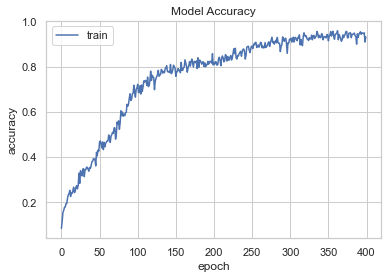

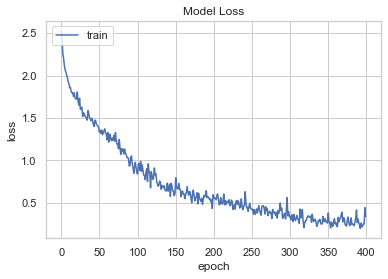

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            488448    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 86.818%


##### Confusion Matrix

220 is the number of test value in kfold_val / train_test_split


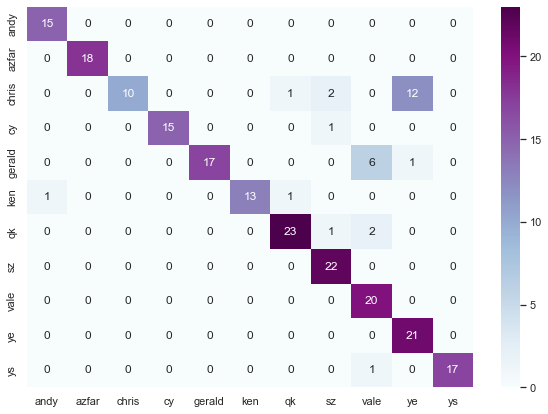

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

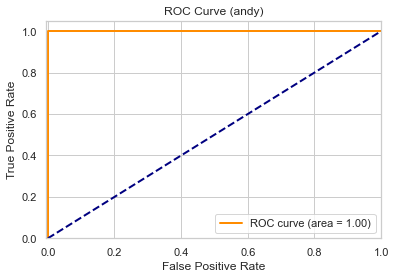

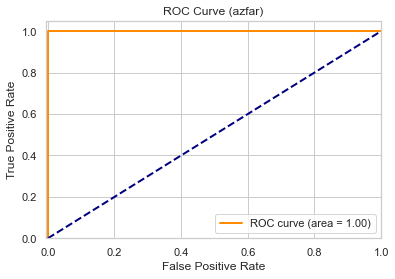

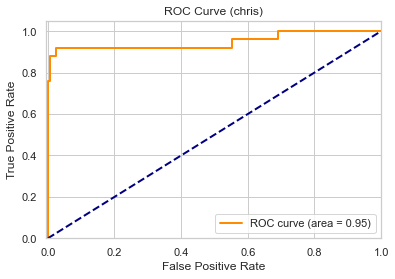

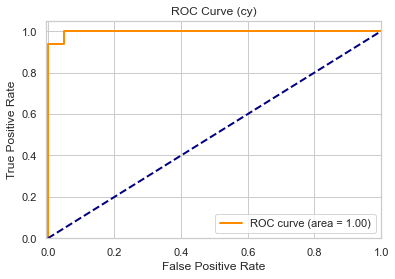

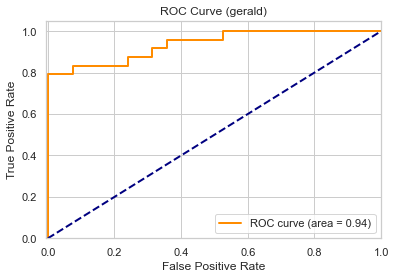

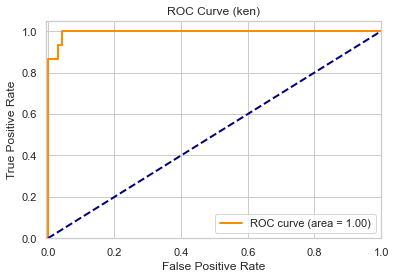

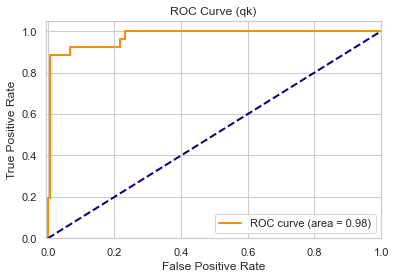

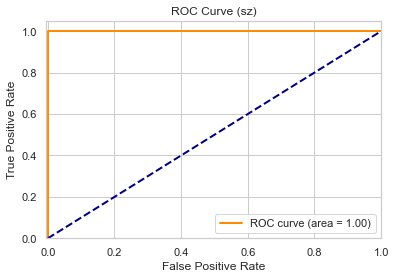

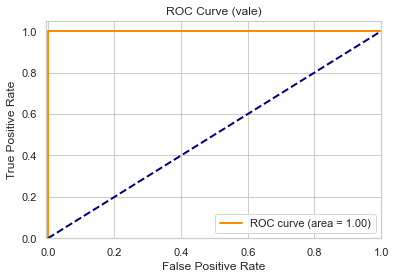

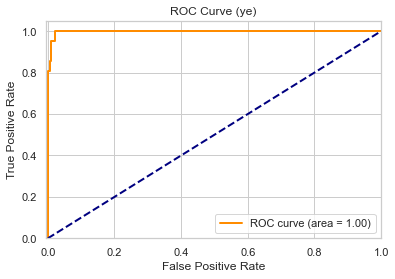

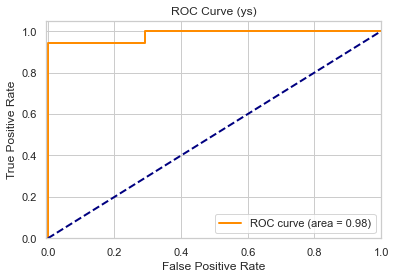

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

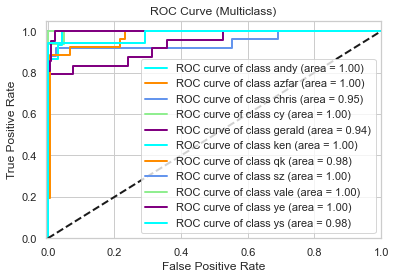

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

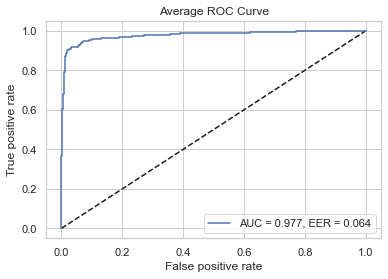

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye' 'ys']


X | Features | Dataset Shape: (1100, 220)
Y | Classes  | Dataset Shape: (1100, 11)
There are a total of 11 classes.
Epoch 1/400
110/110 [==============================] - 6s 10ms/step - loss: 2.5002 - accuracy: 0.0836
Epoch 2/400
110/110 [==============================] - 1s 9ms/step - loss: 2.3163 - accuracy: 0.1245
Epoch 3/400
110/110 [==============================] - 1s 9ms/step - loss: 2.1409 - accuracy: 0.1636
Epoch 4/400
110/110 [==============================] - 1s 9ms/step - loss: 2.0781 - accuracy: 0.1564
Epoch 5/400
110/110 [==============================] - 1s 9ms/step - loss: 2.0160 - accuracy: 0.1691
Epoch 6/400
110/110 [==============================] - 1s 9ms/step - loss: 1.9876 - accuracy: 0.1964
Epoch 7/400
110/110 [==============================] - 1s 9ms/step - loss: 1.9314 - accuracy: 0.2145
Epoch 8/400
110/110 [==============================] - 1s 9ms/ste

110/110 [==============================] - 1s 9ms/step - loss: 0.9596 - accuracy: 0.6873
Epoch 80/400
110/110 [==============================] - 1s 10ms/step - loss: 1.0564 - accuracy: 0.6609
Epoch 81/400
110/110 [==============================] - 1s 9ms/step - loss: 1.0041 - accuracy: 0.6745
Epoch 82/400
110/110 [==============================] - 1s 9ms/step - loss: 1.0045 - accuracy: 0.6582
Epoch 83/400
110/110 [==============================] - 1s 10ms/step - loss: 0.9818 - accuracy: 0.6573
Epoch 84/400
110/110 [==============================] - 1s 11ms/step - loss: 1.0056 - accuracy: 0.6636
Epoch 85/400
110/110 [==============================] - 1s 9ms/step - loss: 1.0053 - accuracy: 0.6591
Epoch 86/400
110/110 [==============================] - 1s 9ms/step - loss: 0.9318 - accuracy: 0.6982
Epoch 87/400
110/110 [==============================] - 1s 9ms/step - loss: 0.9100 - accuracy: 0.6909
Epoch 88/400
110/110 [==============================] - 1s 9ms/step - loss: 0.9355 - accurac

110/110 [==============================] - 1s 9ms/step - loss: 0.6358 - accuracy: 0.8091
Epoch 159/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5353 - accuracy: 0.8509
Epoch 160/400
110/110 [==============================] - 1s 9ms/step - loss: 0.6213 - accuracy: 0.8336
Epoch 161/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5944 - accuracy: 0.8455
Epoch 162/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5929 - accuracy: 0.8418
Epoch 163/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5904 - accuracy: 0.8327
Epoch 164/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5800 - accuracy: 0.8391
Epoch 165/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5076 - accuracy: 0.8555
Epoch 166/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5655 - accuracy: 0.8373
Epoch 167/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5827 - a

110/110 [==============================] - 1s 9ms/step - loss: 0.3281 - accuracy: 0.9209
Epoch 238/400
110/110 [==============================] - 1s 9ms/step - loss: 0.3223 - accuracy: 0.9291
Epoch 239/400
110/110 [==============================] - 1s 9ms/step - loss: 0.4320 - accuracy: 0.9009
Epoch 240/400
110/110 [==============================] - 1s 9ms/step - loss: 0.5768 - accuracy: 0.8527
Epoch 241/400
110/110 [==============================] - 1s 9ms/step - loss: 0.4451 - accuracy: 0.8918
Epoch 242/400
110/110 [==============================] - 1s 9ms/step - loss: 0.4382 - accuracy: 0.9018
Epoch 243/400
110/110 [==============================] - 1s 12ms/step - loss: 0.4562 - accuracy: 0.8864
Epoch 244/400
110/110 [==============================] - 1s 11ms/step - loss: 0.3349 - accuracy: 0.9227
Epoch 245/400
110/110 [==============================] - 1s 11ms/step - loss: 0.3759 - accuracy: 0.9145
Epoch 246/400
110/110 [==============================] - 1s 9ms/step - loss: 0.3878 

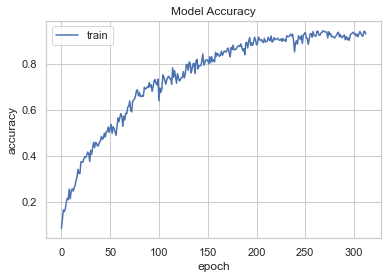

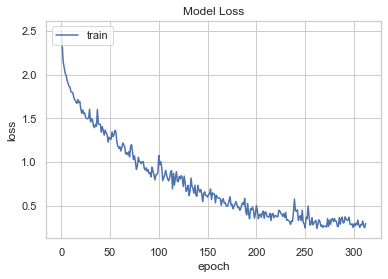

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,Co5mical,0.073992,0.003000,0.076992,0.094482,0.168474,0.091483,0.045362,0.136844,...,0.002609,0.001499,0.042155,0.029788,0.051080,0.038712,0.499024,0.573016,0.566388,0.640380
1,andy,Co5mical,0.100974,0.012187,0.113161,0.101644,0.202618,0.089456,0.033577,0.123034,...,0.004042,0.005144,0.048238,0.056383,0.063579,0.071723,0.518507,0.619481,0.597307,0.698281
2,andy,Co5mical,0.089725,0.045267,0.134991,0.167849,0.257574,0.122583,0.005957,0.128540,...,0.009055,0.005173,0.087968,0.064734,0.095156,0.071922,0.504553,0.594277,0.596016,0.685741
3,andy,Co5mical,0.067997,0.054379,0.122376,0.144052,0.212049,0.089673,0.000993,0.090666,...,0.007376,0.004978,0.081239,0.065912,0.085884,0.070557,0.477528,0.545525,0.563112,0.631109
4,andy,Co5mical,0.102257,0.003956,0.106213,0.089189,0.191446,0.085233,0.045437,0.130670,...,0.002313,0.003616,0.024290,0.036328,0.048092,0.060130,0.470455,0.572712,0.537894,0.640151


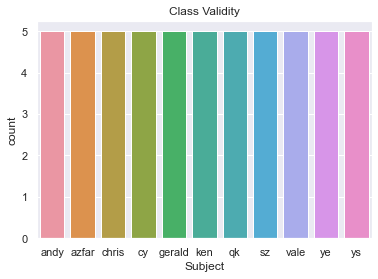

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['andy', 'azfar', 'chris', 'cy', 'gerald', 'ken', 'qk', 'sz', 'vale', 'ye', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

Accuracy of the Model is: 53/55 (96.36363636363636%)


In [32]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:54:14
